In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()

# Lie Operator and Lie Map Implementation

In [2]:
class LieOperator:
    '''
    Lie Operator Class
    '''
    def __init__(self, ham, indep_coords, indep_mom):
        self._ham = ham 
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]

        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
        self._indep_coords = indep_coords
        self._indep_mom = indep_mom
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        h = 0
        for qi,pi in zip(self.indep_coords,self.indep_mom):
            h += self.ham.diff(qi) * other.diff(pi) 
            h -= self.ham.diff(pi) * other.diff(qi)

        return h
    

class LieMap(LieOperator):
    '''
    Lie transform map
    Inherits Lie Operator structure
    '''
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        s = 0
        if power == 0:
            s += other
        else:
            s += self.Poisson(self.ExpPowerLieBracket(other, power - 1))
            
        return s
    
    
    #Calculate the exponential map of the Lie operator to the input cutoff
    def exp(self,other,power):
        s = 0
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*self.ExpPowerLieBracket(other,i)
        return s


n = 4
def pn(n):
    F = sympy.Matrix(np.zeros((n+1,n+1)))
    for i in range(n+1):
        for j in range(n+1):
            if (j-i)>=0:
                F[i,j] = sympy.Rational(1,int(fac(j-i))) # keep it rational !!!!


    
    G = sympy.Matrix(np.zeros((n+1,n+1)))
    for i in range(n+1):
        for j in range(n+1):
            if (j-i)>=0:
                if i==j:
                    sigprod = 1
                else:
                    l = sympy.symbols('s{}:{}'.format(i,j))
                    sigprod = reduce(sympy.Mul,l)
                G[i,j] = sympy.Mul(sympy.Rational(1,int(np.math.factorial(j-i))),sigprod, evaluate=False)



    qthpower = sympy.Matrix(np.eye(n+1))

    FGm1 = sympy.nsimplify(F*G - qthpower)

    FGm1


    summ = 0

    for q in range(1,n+1):
        qthpower = sympy.nsimplify(sympy.MatMul(qthpower, FGm1, evaluate=False))

        summ += sympy.nsimplify((-1)**(q-1)/q * qthpower)[0,n] # q-1 because mathematica starts at 1 and not 0, there for sign change

    return sympy.expand(summ)

def translated(op1,op2,n):
    l = sympy.symbols('s{}:{}'.format(0,n))
    temp = reduce(functools.partial(sympy.Mul,evaluate=False),[k*k for k in l])
    temp = sympy.expand(sympy.Mul(temp, pn(n), evaluate=False),evaluate=False)
    with sympy.evaluate(False):
        ln = sympy.symbols('r{}:{}'.format(0,n), commutative=False)
        for i, s in enumerate(l):
            temp = temp.subs(l[i],ln[i])
        for i in range(n):
            f = sympy.Symbol('f',commutative=False)
            g = sympy.Symbol('g',commutative=False)
            temp = temp.subs(ln[i]**3,g)
            temp = temp.subs(ln[i]**2,f)
            temp = temp.subs(g**0,1)
        
        temp = temp.subs(f,op1)
        temp = temp.subs(g,op2)
    
    return temp

def HCB(op1,op2,n):
    s = 0
    for i in range(1,n+1):
        s+= translated(op1,op2,i)
    return s

In [3]:
x, p = sympy.symbols('x p')
H = sympy.Function('H', commutative=False)(x,p)
g = sympy.Function('g', commutative=False)(x,p)
la = LieOperator(H,x,p)
lb = LieMap(H,x,p)
lc = LieMap(g,x,p)

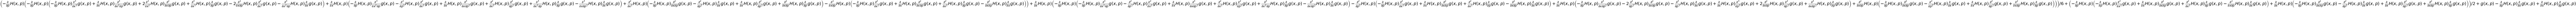

In [4]:
lb.exp(g,3)

# Drift Space numerical calulation

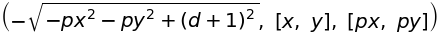

In [5]:
x, y, px, py, delta = sympy.symbols('x y px py d')
Hd = - sympy.sqrt((1+delta)**2 - px**2 - py**2)
drift = LieMap(Hd,[x,y],[px,py])
drift.ham, drift.indep_coords, drift.indep_mom

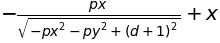

In [6]:
drift.exp(x,10)

In [7]:
drift.exp(px,10)

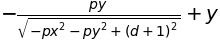

In [8]:
drift.exp(y,10)

In [9]:
drift.exp(py,10)

# Drift Space Term Comparison

In [10]:
x,px,py,delta, L = symbols('x px py d L')
xn = x + L * px/(sqrt((1+delta)**2 - px**2 - py**2))

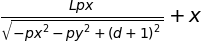

In [11]:
xn

In [12]:
f = xn.subs([(py,1e-05),(delta, 1e-04)])
y1 = series(f.subs(x,0),px,x0=0,n=2).removeO()
y2 = series(f.subs(x,0),px,x0=0,n=4).removeO()
y3 = series(f.subs(x,0),px,x0=0,n=6).removeO()
y4 = series(f.subs(x,0),px,x0=0,n=8).removeO()

In [13]:
y1

In [14]:
y2

In [15]:
y3

In [16]:
y4

In [17]:
lam_y1 = lambdify([px,L], y1)
lam_y2 = lambdify([px,L], y2)
lam_y3 = lambdify([px,L], y3)
lam_y4 = lambdify([px,L], y4)

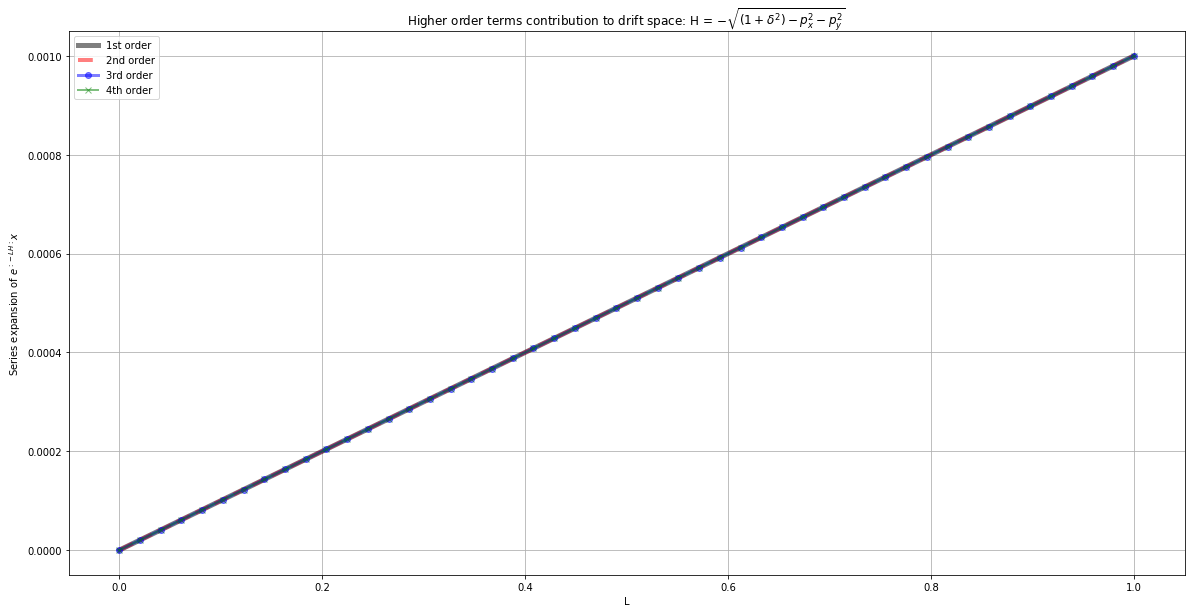

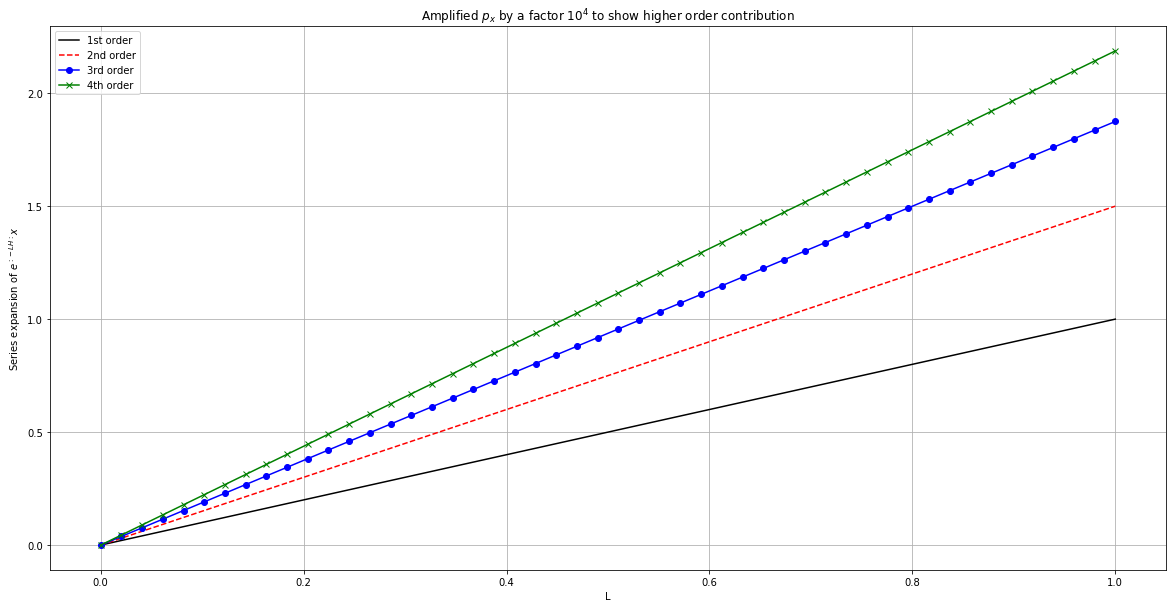

In [18]:
a = np.linspace(0,1)

#Plot size
plt.rcParams['figure.figsize'] = [20, 10]
#Plot
fig1 = plt.figure()
plt.plot(a,lam_y1(10e-4,a),'k',lw=5,alpha=0.5,label='1st order')
plt.plot(a,lam_y2(10e-4,a),'--r',lw=4,alpha=0.5,label='2nd order')
plt.plot(a,lam_y3(10e-4,a),'-ob',lw=3,alpha=0.5,label='3rd order')
plt.plot(a,lam_y4(10e-4,a),'-xg',lw=2,alpha=0.5,label='4th order')



#Cosmetics
plt.title('Higher order terms contribution to drift space: H = $-\sqrt{(1+\delta^2) - p_x^2 - p_y^2}$')
plt.xlabel('L')
plt.ylabel('Series expansion of $e^{:-LH:} x$')
plt.grid()
plt.legend()

plt.show()

#Plot
fig2 = plt.figure()
plt.plot(a,lam_y1(1,a),'k',label='1st order')
plt.plot(a,lam_y2(1,a),'--r',label='2nd order')
plt.plot(a,lam_y3(1,a),'-ob',label='3rd order')
plt.plot(a,lam_y4(1,a),'-xg',label='4th order')



#Cosmetics
plt.title('Amplified $p_x$ by a factor $10^4$ to show higher order contribution')
plt.xlabel('L')
plt.ylabel('Series expansion of $e^{:-LH:} x$')
plt.grid()
plt.legend()
# plt.xlim(0.9975, 1.0001)
#plt.ylim(0.000999900010048985, 0.00099990050989939)

plt.show()

# Thick Quadrupole

In [19]:
from sympy import cos, sin, series
x,p,k, L = sympy.symbols('x p k L')
Hq = -sympy.Rational(1,2)*(L*k*x**2 + p**2)
quadrupole = LieMap(Hq,x,p)
quadrupole.ham, quadrupole.indep_coords, quadrupole.indep_mom

## $e^{:-\frac{1}{2}L(kx^2 + p^2):}x$

In [20]:
quadrupole.exp(x,10)

In [21]:
sympy.series(cos(sympy.sqrt(k))*x,k)

In [22]:
sympy.series(sin(sympy.sqrt(k))*p/sympy.sqrt(k),k)

## $e^{:-\frac{1}{2}L(kx^2 + p^2):}p$

In [23]:
quadrupole.exp(p,10)

In [24]:
sympy.series(-sympy.sqrt(k)*sin(sympy.sqrt(k))*x,k)

In [25]:
sympy.series(cos(sympy.sqrt(k))*p,k)

# Baker - Cambell - Hausdorff

In [26]:
Z = sympy.Function('F', commutative=False)(x,p)
W = sympy.Function('G', commutative=False)(x,p)
h = HCB(Z,W,2)
test = LieMap(h,x,p)
test.ham, test.indep_coords, test.indep_mom

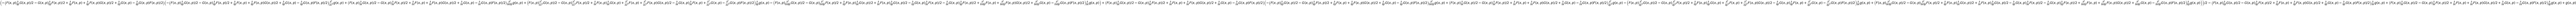

In [27]:
test.exp(g,2)